<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/langchain/Chat_with_Any_Documents_Own_ChatGPT_with_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Environment Setup

In [ ]:
import langchain
print(langchain.__version__)


In [1]:
import os
import openai
from dotenv import load_dotenv
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings import OpenAIEmbeddings

# Load environment variables (set OPENAI_API_KEY and OPENAI_API_BASE in .env)
load_dotenv()

# Configure OpenAI API
openai.api_type = "azure"
openai.api_version = "2023-03-15-preview"
openai.api_base =  os.getenv('OPENAI_API_BASE')
openai.api_key = os.getenv("AZ_OPENAI_API_KEY")

# Initialize gpt-35-turbo and our embedding model
llm = AzureChatOpenAI(deployment_name="cresen-gpt-35-turbo", openai_api_version="2023-03-15-preview") # For Chat
embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002', deployment='text-embedding-ada-002',chunk_size=1) # For Embeddings
#embeddings = OpenAIEmbeddings(deployment="cresen-embedding",model="text-embedding-ada-002")

## 2. Documents Loading

We are using ada embedding from Azure
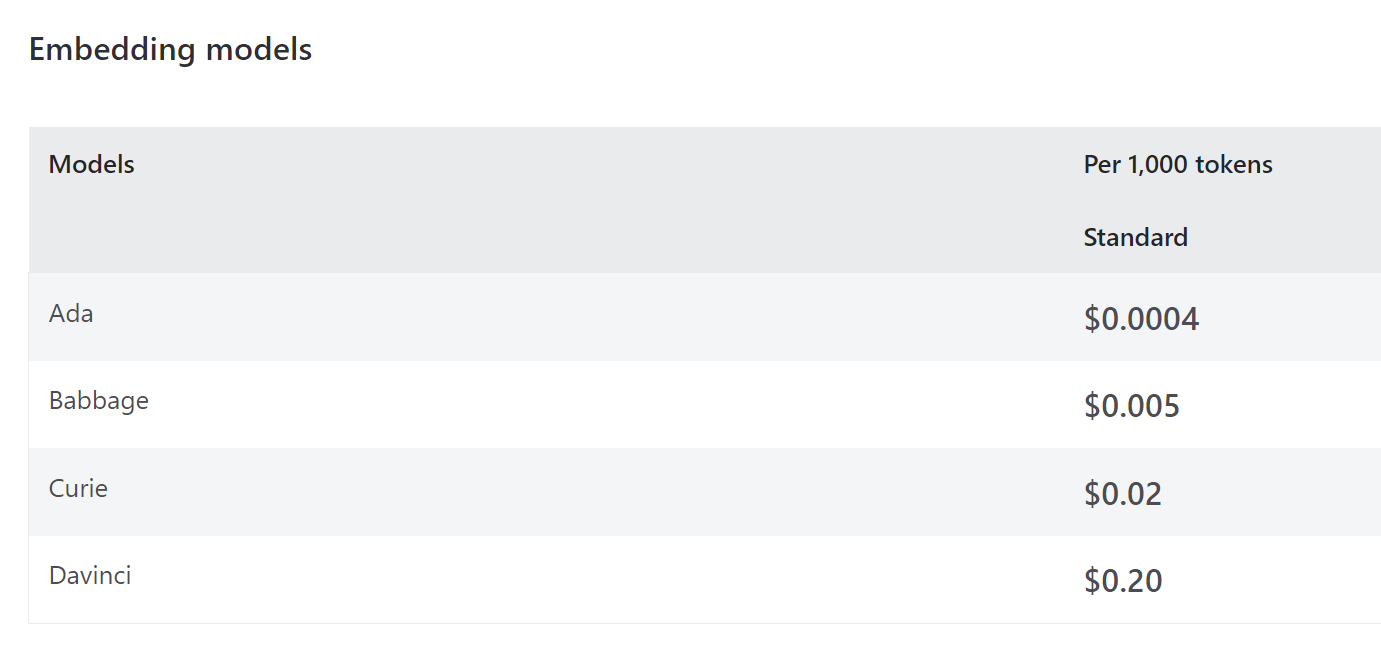 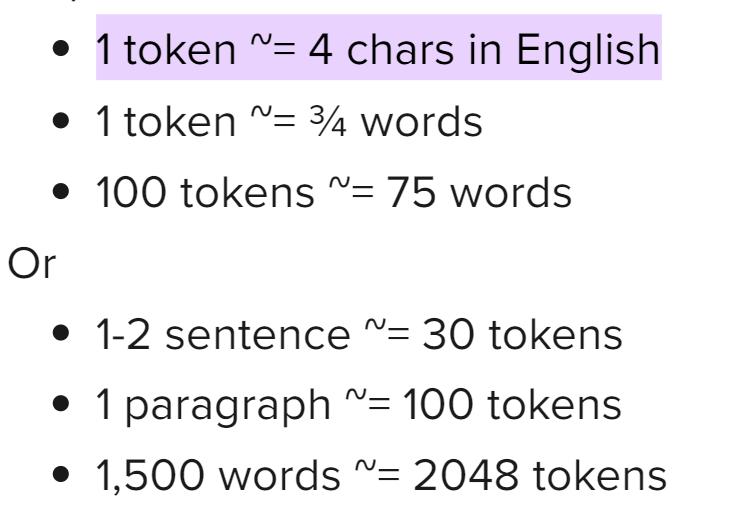

In [4]:
# without multithreading
from langchain.document_loaders import DirectoryLoader
pdf_loader = DirectoryLoader(r"pdfs", glob="**/*.pdf",show_progress=True)
#take all the loader
loaders = [pdf_loader] # , readme_loader, txt_loader
#lets create document 
documents = []
for loader in loaders:
    documents.extend(loader.load())
    
total_characters = len(documents[0].page_content)

print(f'You have {len(documents)} document(s) in your data')
print(f'There are a total of {total_characters} characters in your documents')

# Calculate total number of tokens
total_tokens = total_characters / 4
# Calculate total price for embedding
total_price = (total_tokens * 0.0004) / 1000
print(f'The total price for embedding is $ {total_price}')

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [09:11<00:00,  6.06s/it]

You have 91 document(s) in your data
There are a total of 54173 characters in your documents
The total price for embedding is $ 0.0054173


## 3. Splitting Text from the documents and creating Chunks

In [5]:
from langchain.text_splitter import TokenTextSplitter
from langchain.text_splitter import CharacterTextSplitter
text_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=20) #chunk overlap seems to work better
#text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=40) 
documents = text_splitter.split_documents(documents)
print(len(documents))

1307


## 4. Embedding with Azure Embedding Model and storing it in ChromaDB Vectorestore

Langchain and ChromaDB : https://blog.langchain.dev/langchain-chroma/

In [6]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
from langchain.vectorstores import Chroma
persist_directory = 'db'
vectorstore = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)
vectorstore.persist()

Using embedded DuckDB with persistence: data will be stored in: db


In [ ]:
#from langchain.vectorstores import FAISS
#db = FAISS.from_documents(documents=documents, embedding=embeddings)

In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate

# Adapt if needed
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template("""Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:""")

qa = ConversationalRetrievalChain.from_llm(llm=llm,
                                           retriever=vectorstore.as_retriever(),
                                           condense_question_prompt=CONDENSE_QUESTION_PROMPT,
                                           return_source_documents=True,
                                           verbose=False)


## Setup

%%capture
!pip install openai langchain  tiktoken pypdf unstructured[local-inference] gradio chromadb
!pip install watermark
!pip install chromadb
pip install unstructured
pip install pdf2image
pip install pytesseract
pip install detectron2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [ ]:
%reload_ext watermark
%watermark -a "Ananthu Raj C M" -vmp langchain,openai,chromadb

In [18]:
import os
from langchain.text_splitter import CharacterTextSplitter
#from langchain.vectorstores Chroma
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI

from langchain.chat_models import AzureChatOpenAI


### Using Chroma for storing vectors

In [ ]:
pip install chromadb

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
from langchain.vectorstores import Chroma
persist_directory = 'db'

embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents=documents, embedding=embedding, persist_directory=persist_directory)

## Querying from ChromaDB

In [ ]:
vectorstore = Chroma.from_documents(documents, embeddings,persist_directory=persist_directory)

## Loading Vectors from Local

In [2]:
# Now we can load the persisted database from disk, and use it as normal. 
from langchain.vectorstores import Chroma
persist_directory = 'db'
vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
vectorstore.persist()

Using embedded DuckDB with persistence: data will be stored in: db


In [ ]:
query = "What is brigatinib ?"
docs = vectorstore.similarity_search(query)

In [ ]:
docs 

In [ ]:
print(docs[0].page_content)

## Now the langchain part (Chaining with Chat History) 
- There are many chains but we use this [link](https://python.langchain.com/en/latest/modules/chains/index_examples/chat_vector_db.html)

In [ ]:
from langchain.llms import OpenAI

In [3]:
from langchain.chains import ConversationalRetrievalChain
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k":5})
qa = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever)

In [ ]:
chat_history = []
query = "What is Ablysinol?"
result = qa({"question": query, "chat_history": chat_history})
result["answer"]

In [ ]:
chat_history.append((query, result["answer"]))
chat_history

In [ ]:
query = "What is sepndmate?"
result = qa({"question": query, "chat_history": chat_history})
result["answer"]

## Create a chatbot with memory with  widgets

In [4]:
from IPython.display import display
import ipywidgets as widgets

chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thanks for the chat!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="Orange">Chatbot:</font></b> {result["answer"]}'))

print("Chat with your data. Type 'exit' to stop")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Chat with your data. Type 'exit' to stop


Text(value='', placeholder='Please enter your question:')

## Gradio Part (Building the [chatbot like UI](https://gradio.app/docs/#chatbot))

### Gradio sample example

In [ ]:
import gradio as gr
import random

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")

    def respond(message, chat_history):
        print(message)
        print(chat_history)
        bot_message = random.choice(["How are you?", "I love you", "I'm very hungry"])
        chat_history.append((message, bot_message))
        print(chat_history)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(debug=True, share=True)

### Gradio langchain example

In [ ]:
import gradio as gr
with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")
    
    def respond(user_message, chat_history):
        print(user_message)
        print(chat_history)
        # Get response from QA chain
        response = qa({"question": user_message, "chat_history": chat_history})
        # Append user message and response to chat history
        chat_history.append((user_message, response["answer"]))
        print(chat_history)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot], queue=False)
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ee7f63c22bf419e277.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


what is ALUNBRIG
[]
[('what is ALUNBRIG', 'ALUNBRIG is a medication used to treat a specific type of lung cancer called non-small cell lung cancer (NSCLC) that has a genetic mutation called anaplastic lymphoma kinase (ALK). It contains the active ingredient brigatinib, which is a tyrosine kinase inhibitor that works by blocking the growth of cancer cells. ALUNBRIG is available in the form of oral tablets.')]
what are the ingredients of ALUNBRIG ?
[['what is ALUNBRIG', 'ALUNBRIG is a medication used to treat a specific type of lung cancer called non-small cell lung cancer (NSCLC) that has a genetic mutation called anaplastic lymphoma kinase (ALK). It contains the active ingredient brigatinib, which is a tyrosine kinase inhibitor that works by blocking the growth of cancer cells. ALUNBRIG is available in the form of oral tablets.']]


Traceback (most recent call last):
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\routes.py", line 422, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1323, in process_api
    result = await self.call_function(
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1051, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run

what are the ingredients of ALUNBRIG ?
[]
[('what are the ingredients of ALUNBRIG ?', 'The active ingredient in ALUNBRIG is brigatinib. The inactive ingredients include lactose monohydrate, microcrystalline cellulose, sodium starch glycolate (Type A), magnesium stearate, and hydrophobic colloidal silica. The tablet coating consists of talc, polyethylene glycol, polyvinyl alcohol, and titanium dioxide.')]
 when was ALUNBRIG approved ?
[['what are the ingredients of ALUNBRIG ?', 'The active ingredient in ALUNBRIG is brigatinib. The inactive ingredients include lactose monohydrate, microcrystalline cellulose, sodium starch glycolate (Type A), magnesium stearate, and hydrophobic colloidal silica. The tablet coating consists of talc, polyethylene glycol, polyvinyl alcohol, and titanium dioxide.']]


Traceback (most recent call last):
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\routes.py", line 422, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1323, in process_api
    result = await self.call_function(
  File "C:\Users\Ananthu Raj C M\AppData\Roaming\Python\Python39\site-packages\gradio\blocks.py", line 1051, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run